# Background Model

Here we calculate the background model of Light-1 initially for a specific species and then for a the addition of the species in the atmosphere.

## Single Species

We will calculate the expected number of hits within a time $T$ on the satellite arizing from particle $\chi$. We know the following:

$$\bar{\Phi}_\chi (E) \vcentcolon = \mathbb{E}_\Phi \left[ f_\chi (\Phi, E)\right]$$
$$f_\chi (E) \vcentcolon = \frac{\bar{\Phi}_\chi (E)}{|| \bar{\Phi}_\chi (E) ||}$$

Where $E$ is the energy of the particle, $\Phi$ is the flux of the particle, $f_\chi (\Phi, E)$ is the probability distribution of finding a particular flux of particles $\chi$ with a specific energy $E$ in the atmosphere. 

Notice that we don't actually know the latter distribution, but we won't need to in order to proceed with the background model. All we need is the probability distribution of obtainining a particle with energy $E$ aka $f_\chi (E)$, and the average flux at that particular energy $\bar{\Phi}_\chi (E)$.

We also know that observing a particle is a poisson process. Since we know the expected flux of the particles we can find the probability of obtaining $n$ particles within time $T$ given that they have energy $\varepsilon$.

$$P(N=n \mid E=\varepsilon) = \frac{\lambda(\varepsilon) ^n}{n!} e^{-\lambda(\varepsilon)}$$

Where $\lambda(\varepsilon)$ is the expected rate of events given by

$$\lambda(\varepsilon) = \bar{\Phi}_\chi (\varepsilon) A_{\chi}(\varepsilon) T$$

where $A_{\chi}(\varepsilon)$ is the effective cross sectional area of the satellite for particle $\chi$. This depends on the energy as lower energy particles are more likely to not penetrate the outer layers and reach the detector. This parameter can be given by

$$A_\chi (\varepsilon) = A_{\text{cross}} P_{\chi}(\varepsilon)$$

wheere $A_{\text{cross}}$ is the cross sectional area of the detector, and $P_{\chi}(\varepsilon)$ is the probability that a particle $\chi$ with energy $\varepsilon$ will be thermalized in one of the detectors.

Finally the probability of obtaining $n$ events of species $\chi$ regardless of the energy is going to be:

$$P(N=n) = \int_{\mathbb{R}}d\varepsilon\ P(N=n \mid E=\varepsilon)\, f_\chi(\varepsilon)$$

## Calculation

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm

%matplotlib widget

In [2]:
# Load all the data
species = ['Protons','Electrons','Gammas']
labels  = ['energy','flux','distribution','integral']

# Create a dictionary
flux_data = {}

# For all the species
for s in species:
    # Read the data
    full_data = pd.read_csv(f'./data/{s}.csv').to_numpy().T

    # Create a subdictionary
    flux_data[s] = {
        'energy':       full_data[0],
        'flux':         full_data[1],
        'integral':     np.sum(full_data[1][:-1]*(full_data[0][1:] - full_data[0][:-1])),
        'distribution': full_data[1]/np.sum(full_data[1][:-1]*(full_data[0][1:] - full_data[0][:-1]))
    }

# Plot all the distributions
fig     = plt.figure(figsize=(5*len(species),4*3),dpi=80)
axes    = [fig.add_subplot(4,len(species),i) for i in range(1,4)]
main    = fig.add_subplot(4,1,(2,4))
fig.set_tight_layout(tight=True)

# Make the plots
for ax,s in zip(axes,species):
    # Plot the smaller axes
    ax.plot(flux_data[s]['energy'],flux_data[s]['flux'],label=s)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Energy [MeV]')
    ax.set_ylabel('Flux')
    ax.legend(frameon=False)

    main.plot(flux_data[s]['energy'],flux_data[s]['flux'],label=s)

# Create and plot the total flux

# Get a single energy axis
min_energy  = np.min([j for i in [flux_data[s]['energy'] for s in species] for j in i])
max_energy  = np.max([j for i in [flux_data[s]['energy'] for s in species] for j in i])
energy      = np.exp(np.linspace(np.log(min_energy*1.01),np.log(max_energy),1000))
flux_tot    = np.zeros(energy.shape)

# For each species
for s in species:
    # Get the relevant energy subsections
    min_e = np.min(flux_data[s]['energy'])
    max_e = np.max(flux_data[s]['energy'])
    idx = np.where((energy >= min_e) & (energy <= max_e))[0]

    flux_tot[idx] += np.interp(energy[idx],flux_data[s]['energy'],flux_data[s]['flux'])

main.plot(energy, flux_tot,label='TOTAL')

# Prettify
main.set_xlim(min(energy),max(energy))
main.set_xscale('log')
main.set_yscale('log')
main.set_xlabel('Energy [MeV]')
main.set_ylabel('Flux')
main.legend(frameon=False)

FileNotFoundError: [Errno 2] No such file or directory: './data/Protons.csv'

In [3]:
# Load the Geant4 Data
geant = {}
for s in species:
    geant_data          = pd.read_csv(f'./data/{s}-geant.txt',sep='*',header='infer')   # Load the data
    geant_data.columns  = geant_data.columns.str.strip()                                # Remove whitespace from the headers
    geant[s]            = geant_data                                                    # Add it on the dictionary

FileNotFoundError: [Errno 2] No such file or directory: './data/Protons-geant.txt'

In [4]:
# Get the spectra
geant_spectra = {}

for s in species:
    hist, energy = np.histogram(geant[s]['EdepTOT'],bins=1000, density=True)
    energy = (energy[1:] + energy[:-1])/2

    geant_spectra[s] = {
        'energy':   energy,
        'spectrum':  hist*flux_data[s]['integral'],
        'density':  hist
    }

KeyError: 'Protons'

KeyError: 'Gammas'

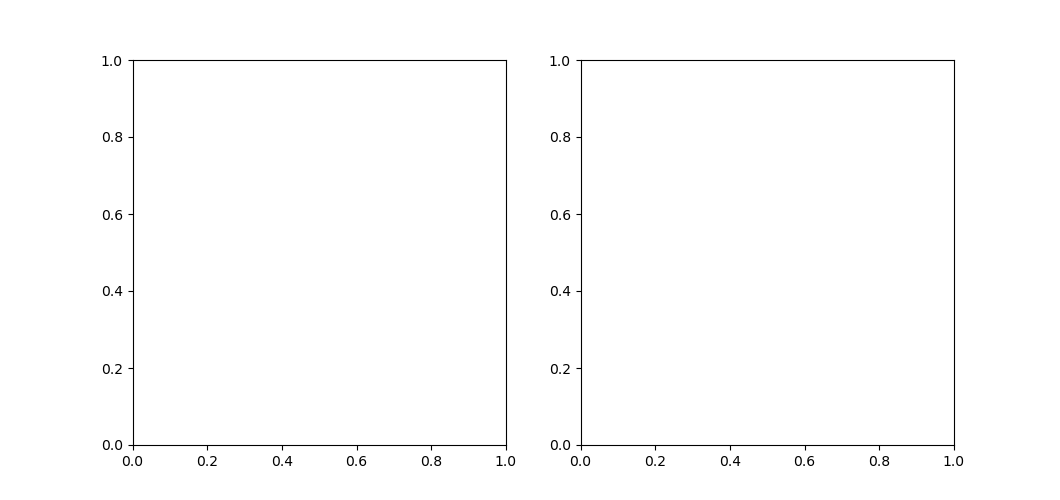

In [5]:
THRESHOLD = 1e-1

sp = species[2]

# Plot the total energy deposited as a function of the total initial energy
fig = plt.figure(figsize=(2*5.3,5))
ax  = [fig.add_subplot(121),fig.add_subplot(122)]
ax[0].scatter(geant[sp]['nrgpri'],geant[sp]['EdepTOT'],s=0.1,alpha=0.3,c='darkblue')
# ax[0].fill_between([min(geant[s]['nrgpri']),max(geant[s]['nrgpri'])],THRESHOLD,alpha=0.3,color='deepskyblue')
ax[0].set_xlabel('Intial Particle Energy [MeV]')
ax[0].set_ylabel('Total Energy Deposited on Detectors [MeV]')
ax[0].set_title('DETECTORS')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(1e-3)
# ax[0].set_xlim(min(geant[s]['nrgpri']),max(geant[s]['nrgpri']))

ax[1].scatter(geant[sp]['nrgpri'],geant[sp]['EdepVETO'],s=0.1,alpha=0.3,c='darkred')
# ax[1].fill_between([min(geant[s]['nrgpri']),max(geant[s]['nrgpri'])],THRESHOLD,alpha=0.3,color='deepskyblue')
ax[1].set_xlabel('Intial Particle Energy [MeV]')
ax[1].set_ylabel('Total Energy Deposited on VETO [MeV]')
ax[1].set_title('VETO')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(1e-3)
ax[1].set_xlim(min(geant[sp]['nrgpri']),max(geant[sp]['nrgpri']))

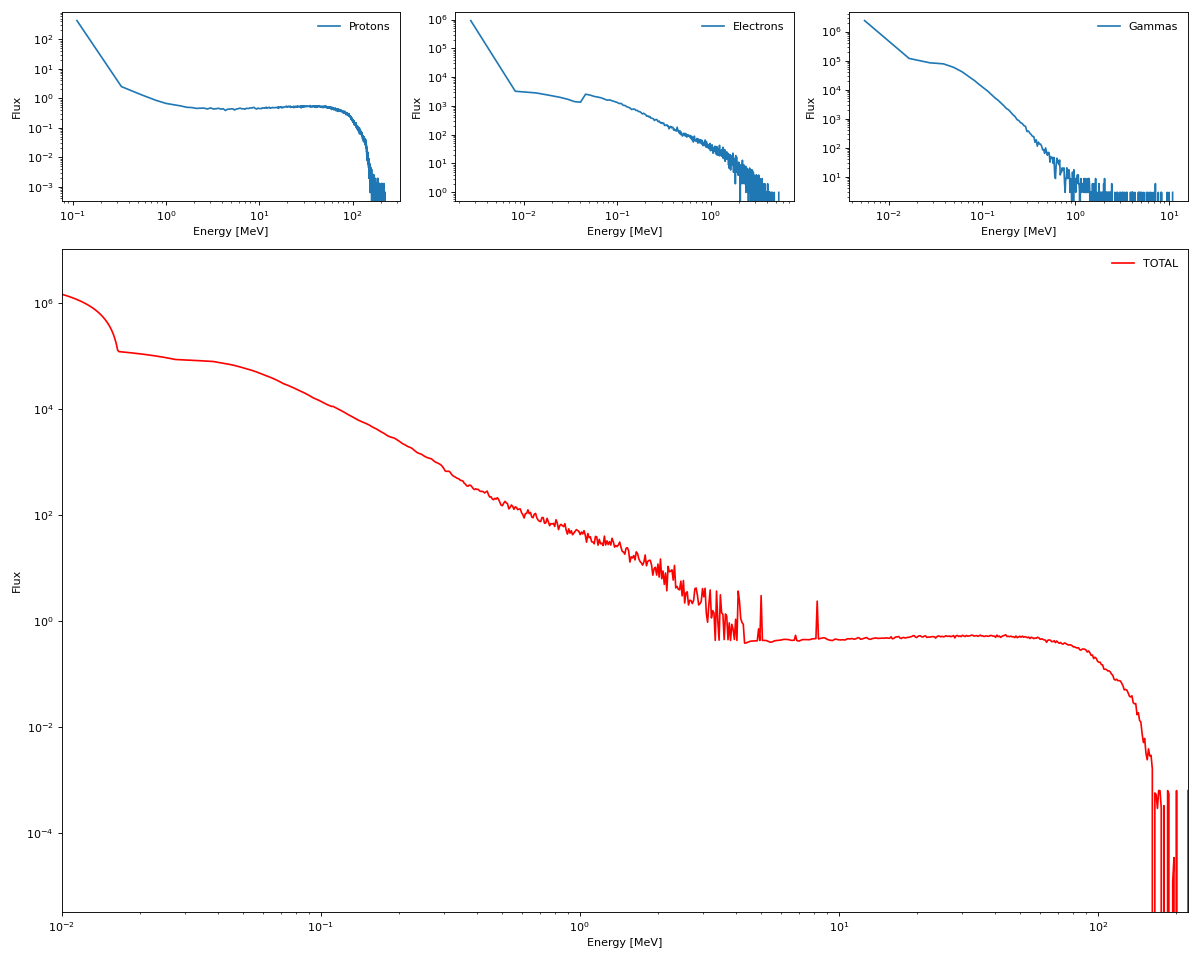

In [6]:
# Load all the data
# Plot all the distributions
fig     = plt.figure(figsize=(5*len(species),4*3),dpi=80)
axes    = [fig.add_subplot(4,len(species),i) for i in range(1,4)]
main    = fig.add_subplot(4,1,(2,4))
fig.set_tight_layout(tight=True)

# Make the plots
for ax,s in zip(axes,species):
    # Plot the smaller axes
    ax.plot(geant_spectra[s]['energy'],geant_spectra[s]['spectrum'],label=s)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Energy [MeV]')
    ax.set_ylabel('Flux')
    ax.legend(frameon=False)

    # main.plot(geant_spectra[s]['energy'],geant_spectra[s]['spectrum'],label=s)

# Create and plot the total flux

# Get a single energy axis
min_energy  = np.min([j for i in [geant_spectra[s]['energy'] for s in species] for j in i])
max_energy  = np.max([j for i in [geant_spectra[s]['energy'] for s in species] for j in i])
energy      = np.exp(np.linspace(np.log(min_energy*1.01),np.log(max_energy),1000))
spec_total  = np.zeros(energy.shape)

# For each species
for s in species:
    # Get the relevant energy subsections
    min_e = np.min(geant_spectra[s]['energy'])
    max_e = np.max(geant_spectra[s]['energy'])
    idx = np.where((energy >= min_e) & (energy <= max_e))[0]

    spec_total[idx] += np.interp(energy[idx],geant_spectra[s]['energy'],geant_spectra[s]['spectrum'])

main.plot(energy, spec_total,label='TOTAL',c='red')

# Prettify
main.set_xlim(min(energy),max(energy))
main.set_xscale('log')
main.set_yscale('log')
main.set_xlabel('Energy [MeV]')
main.set_ylabel('Flux')
main.set_xlim(1e-2)
main.legend(frameon=False)

# SPENVIS
First load the spenvis data along the golden month orbit

In [2]:
## The data file
data_file_p = './Atmospheric_Spectra_SPENVIS/SPECTRA/spenvis_trapped_proton_spectra_orbit.txt'
data_file_e = './Atmospheric_Spectra_SPENVIS/SPECTRA/spenvis_trapped_electron_spectra_orbit.txt'
orbit_file  = './Atmospheric_Spectra_SPENVIS/INPUT_DATA/spenvis_orbit_positions.txt'

# Load the orbit data
def read_orbit_file(data_file:str):
    ## Read the header
    file        = open(data_file,'r')
    lines       = file.readlines()
    file.close()

    ## Extract the spectra for each trajectory point
    header      = [x.strip() for x in lines[0].split(',')]
    start_from  = int(header[1])
    data        = np.array([[float(x.strip()) for x in line.split(',')] for line in lines[start_from:-1]])
    
    return data


def read_flux_file(data_file:str):
    ## Read the header
    file        = open(data_file,'r')
    lines       = file.readlines()
    file.close()

    ## Extract the spectra for each trajectory point
    header      = [x.strip() for x in lines[0].split(',')]
    start_from  = int(header[1])
    data        = np.array([[float(x.strip()) for x in line.split(',')[2:]] for line in lines[start_from:-1]])

    # Extract the energy
    energies = []
    for line in lines:
        if "'ENERGY'" in line: 
            energies = np.array([float(x.strip()) for x in line.split(',')[2:-1]])
            break
    
    return data,energies

# Plot the spectra on one axis
def plot_lines(ax,data,energies,**kwargs):
    for spectra in data:
        if np.sum(spectra>0):
            plot_spectra = spectra.copy()
            plot_spectra[np.where(spectra==0)] = None
            ax.plot(energies,plot_spectra,**kwargs)


In [3]:
from datascience import *

def plot_solar(ax,flux,energies,**kwargs):
    if np.sum(flux>0):
        plot_spectra = flux.copy()
        plot_spectra[np.where(flux==0)] = None
        ax.plot(energies,plot_spectra,**kwargs)

In [4]:

solar= Table.read_table('./Atmospheric_Spectra_SPENVIS/SPECTRA/solar_particle_orbit.csv')
solar

Particle,Energy (MeV),Average flux (/cm^2/s)
Proton,0.1,1190
Proton,0.15,969
Proton,0.2,754
Proton,0.3,464
Proton,0.4,308
Proton,0.5,206
Proton,0.6,153
Proton,0.7,116
Proton,1,62.3
Proton,1.5,28


In [5]:
solar_electron          = solar.where('Particle', are.containing('Electron'))
solar_electron_energy   = solar_electron.column('Energy (MeV)')
solar_electron_flux     = solar_electron.column('Average flux (/cm^2/s)')

In [6]:
solar_proton        = solar.where('Particle', are.containing('Proton'))
solar_proton_energy = solar_proton.column('Energy (MeV)')
solar_proton_flux   = solar_proton.column('Average flux (/cm^2/s)')

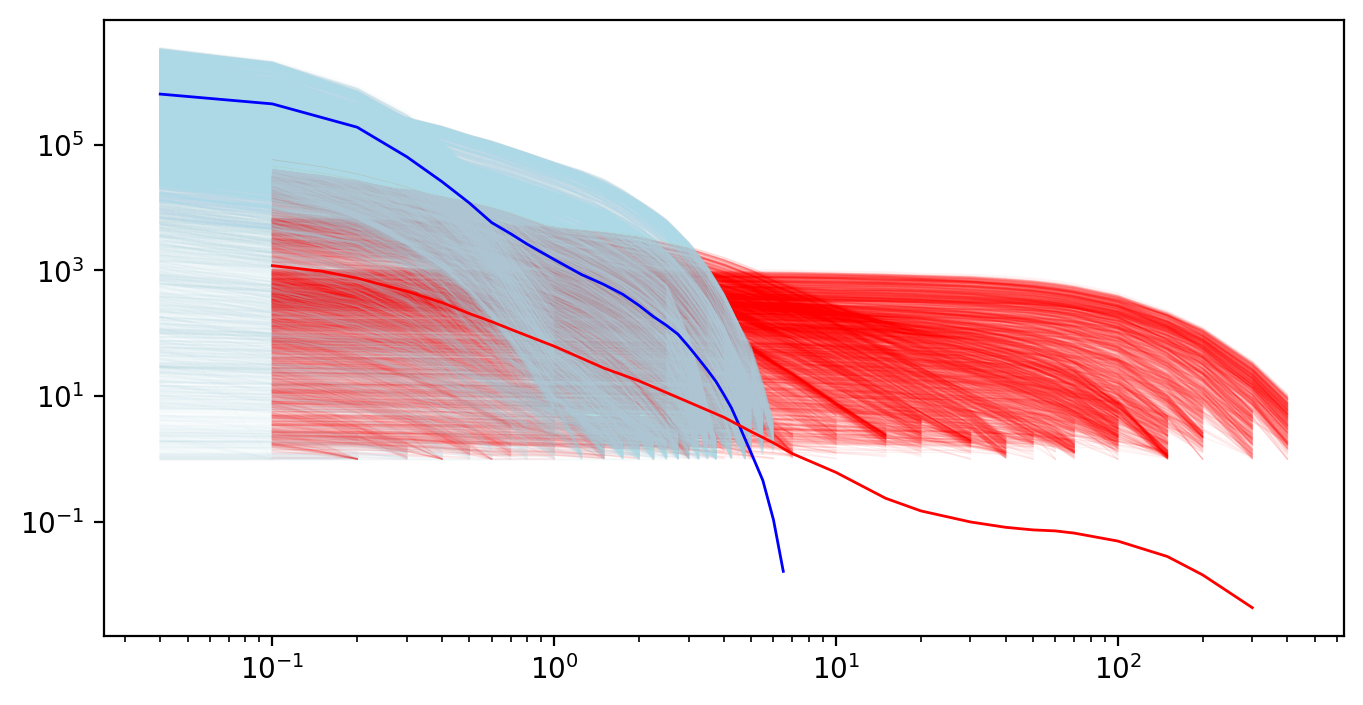

In [7]:
# Create a plot
fig = plt.figure(figsize=(8,4),dpi=200)
ax  = fig.add_subplot(111)

# Add the line 
for file,color in zip([data_file_p,data_file_e,],['red','lightblue']):
    plot_lines(ax,*read_flux_file(file),c=color,lw=0.5,alpha=0.05)

plot_solar(ax, solar_electron_flux, solar_electron_energy, c = 'blue', lw=1)
plot_solar(ax, solar_proton_flux, solar_proton_energy, c = 'red', lw=1)

# Style the plot
ax.set_yscale('log')
ax.set_xscale('log')
fig

In [26]:
# Read the data files
protons, energies_p     = read_flux_file(data_file_p)
idx_protons             = [i for i,x in enumerate(protons)      if np.sum(x!=0)]
electrons, energies_e   = read_flux_file(data_file_e)
idx_electrons           = [i for i,x in enumerate(electrons)    if np.sum(x!=0)]
orbit                   = read_orbit_file(orbit_file)

# Fitting polynomials

We will use splines to fit the distribution for each thing, then integrate that to produce the cumulative

In [9]:
## Get the probability distribution
II      = 20

def get_distribution(energy, flux, N = 100):
    # If there are repeated entries remove them
    no_one  = np.where(flux!=0)[0]
    no_one  = np.append(no_one,[no_one[-1]+1],axis=0)

    # Get the flux and energy
    flux    = flux[no_one]
    energy  = energy[no_one]
    
    # Calculate the PDF
    dE      = np.append([0],energy[1:] - energy[:-1],axis=0)
    pdf     = flux / np.sum(flux*dE)

    # Fit
    model       = lambda x,A,B,C,D: D - A /(1+ C*x**B)
    popt, _  = curve_fit(model,energy,pdf,method="trf")
    x   = np.linspace(min(energy),max(energy),100)

    return x, abs(model(x,*popt)/max(model(x,*popt)))

def create_spectrum_file(filename, energy, probability, unit:str = 'MeV'):
    # open the file
    file = open(filename,"w")
    
    # Write the unit
    file.write(unit+'\n')

    # Write hte number of entries
    file.write(str(len(energy)) + '\n')

    # Write the spectra
    for e, p in zip(energy, probability): file.write("%.10f %.10f\n"%(e,p))

# Create the spectrum file
# create_spectrum_file('spec.txt',*get_distribution(energies_p, protons[idx_protons[II]]),'MeV')

In [10]:
# Filter the selected spectra with the ones that can be fitted

def filter_idx(idx,energies,fluxes):
    keep = [True]*len(idx)

    for I,i in enumerate(tqdm(idx)):
        try:
            get_distribution(energies,fluxes[i])
        except Exception:
            keep[I] = False

    return keep

keep_p        = filter_idx(idx_protons,energies_p,protons)
idx_protons   = list(np.array(idx_protons)[keep_p])

keep_e        = filter_idx(idx_electrons,energies_e,electrons)
idx_electrons = list(np.array(idx_electrons)[keep_e])

keep_solar    = 


  0%|          | 0/4138 [00:00<?, ?it/s]

/Users/ti602/miniconda3/envs/RAAD2/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


  0%|          | 0/6482 [00:00<?, ?it/s]

/var/folders/xn/fqh9dg492s181l087ny89g2m0000gp/T/ipykernel_56749/563244368.py:18: RuntimeWarning: overflow encountered in power
  model       = lambda x,A,B,C,D: D - A /(1+ C*x**B)


# Create the spectra files


In [11]:
# Set the root directory
root        = './spectra/'
particle    = 'proton'
idx         = idx_protons
Npts        = 100
energies    = energies_p
fluxes      = protons
unit        = 'MeV'

# Create the files for the protons
for i in tqdm(idx):
    # Create a file in that directory
    filename =  root+particle+'/'+str(orbit[i][0])+'.txt'
    create_spectrum_file(filename,*get_distribution(energies,fluxes[i],Npts),unit)

  0%|          | 0/3129 [00:00<?, ?it/s]

In [12]:
# Set the root directory
root        = './spectra/'
particle    = 'electron'
idx         = idx_electrons
Npts        = 100
energies    = energies_e
fluxes      = electrons
unit        = 'MeV'

# Create the files for the protons
for i in tqdm(idx):
    # Create a file in that directory
    filename =  root+particle+'/'+str(orbit[i][0])+'.txt'
    create_spectrum_file(filename,*get_distribution(energies,fluxes[i],Npts),unit)

  0%|          | 0/6381 [00:00<?, ?it/s]

# Create the Macro File

In [13]:
def generate_macros(root,particle,filenames,Nparticles):
    # Generate the macro file
    file        = open(root+particle+'.mac',"w")

    # Do some initial setup
    file.write(f'/light1/selectParticle {particle}\n\n')
    file.write(f"/analysis/setNtupleDirName {particle}\n")

    # Shoot some particles for each file
    for i, fname in enumerate(filenames):
        file.write(f"/analysis/setFileName {particle}-{fname}.csv\n")
        file.write(f"/light1/setSpectrum ./spectra/{particle}/{fname}.txt\n")
        file.write(f"/run/beamOn {Nparticles}\n\n")

In [14]:
# Set some parameters
root        = './macros/'
particle    = 'proton'
filenames   = orbit[idx_protons][:,0]
Nparticles  = 5000

generate_macros(root,particle,filenames,Nparticles)

# Set some parameters
root        = './macros/'
particle    = 'electron'
filenames   = orbit[idx_electrons][:,0]
Nparticles  = 5000

generate_macros(root,particle,filenames,Nparticles)

# Create a complete flux distribution

In [15]:
# Get the total flux
def get_total_flux(fluxes,energy):
    total_flux = np.sum(fluxes, axis=0)

    # Calculate the PDF
    dE      = np.append([0],energy[1:] - energy[:-1],axis=0)
    pdf     = total_flux / np.sum(total_flux*dE)

    return total_flux, pdf
total_flux_p, pdf = get_total_flux(protons, energies_p)
total_flux_e, pdf = get_total_flux(electrons, energies_e)
create_spectrum_file('total_protons.txt',energies_p,pdf/max(pdf))

In [16]:
I_e = np.sum(total_flux_e[:-1]*(energies_e[1:] - energies_e[:-1]))
I_p = np.sum(total_flux_p[:-1]*(energies_p[1:] - energies_p[:-1]))
print(I_p,I_e,I_p/I_e,I_e/I_p)

61139163.44456002 588753539.1370319 0.1038450886158154 9.629728409203764


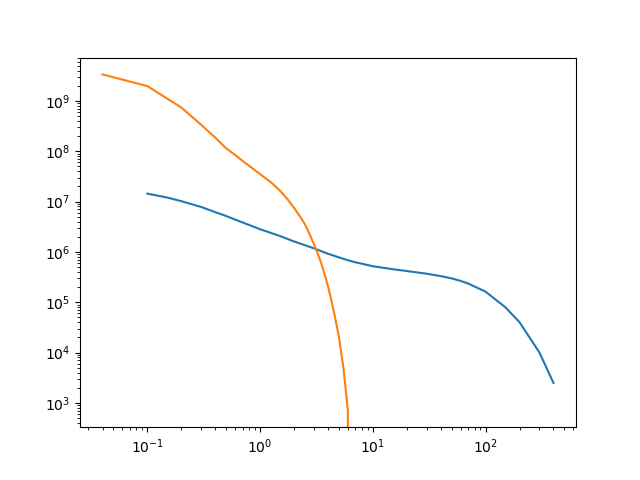

In [17]:
plt.figure()
plt.plot(energies_p,total_flux_p)
plt.plot(energies_e,total_flux_e)
plt.xscale('log')
plt.yscale('log')

# Geant4 Data analysis


In [91]:
geant_e = pd.read_csv('./Data/GEANT4-OUTPUT/electron_bg.csv').to_numpy().T
geant_p = pd.read_csv('./Data/GEANT4-OUTPUT/proton_bg.csv').to_numpy().T